In [110]:
from transformers import Wav2Vec2ForCTC
from transformers import Wav2Vec2Processor
from scipy.io.wavfile import write
from IPython.display import Audio

import matplotlib.pyplot as plt
import sounddevice as sd
import noisereduce as nr
import soundfile as sf
import librosa.display
import numpy as np
import librosa
import torch

In [111]:
model_dir = "C:/Users/ADMIN/Desktop/clean_data/model_v3_mask_timit/phoneme_recognition_v3/kaggle/working/phoneme_recognition_v3"
processor = Wav2Vec2Processor.from_pretrained(model_dir)
model = Wav2Vec2ForCTC.from_pretrained(model_dir)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec

In [112]:
# Check vocal
vocab = processor.tokenizer.get_vocab()
# vocab

In [113]:
# Hàm ghi âm và lưu file WAV
def record_and_save_wav(filename="recorded_audio.wav", duration=5, sample_rate=16000):
    print(f"Đang ghi âm trong {duration} giây...")
    
    # Ghi âm từ microphone
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()  
    
    # Chuẩn hóa biên độ (nếu cần)
    recording = recording / np.max(np.abs(recording))
    
    # Lưu file WAV
    write(filename, sample_rate, recording)
    print(f"Đã lưu file âm thanh tại: {filename}")
    
    # Phát lại để kiểm tra (tùy chọn)
    display(Audio(filename))

# Gọi hàm để ghi âm
record_and_save_wav(filename="recorded_audio.wav", duration=2, sample_rate=16000)

Đang ghi âm trong 2 giây...
Đã lưu file âm thanh tại: recorded_audio.wav


In [114]:
# Hàm xử lý âm thanh
def clean_audio(speech, sample_rate):
    # Bước 1: Giảm tiếng ồn nền
    speech = nr.reduce_noise(
        y=speech,
        sr=sample_rate,
        stationary=False,  
        prop_decrease=0.6  
    )

    speech, _ = librosa.effects.trim(speech, top_db=60)

    return speech

audio_path = "./recorded_audio.wav"
# audio_path = "C:/Users/ADMIN/Desktop/clean_data/data_draw/audio_files_wav/public.wav"
speech, sample_rate = sf.read(audio_path)

if sample_rate != 16000:
    speech = librosa.resample(speech, orig_sr=sample_rate, target_sr=16000)
    sample_rate = 16000

speech = clean_audio(speech, sample_rate)

inputs = processor(speech, sampling_rate=sample_rate, return_tensors="pt", padding=True)

print(inputs['input_values'])
input_values = inputs.input_values.to(device)

tensor([[ 0.0092,  0.0093,  0.0073,  ..., -0.0004, -0.0066, -0.0100]])


In [115]:
display(Audio(speech, rate=sample_rate))

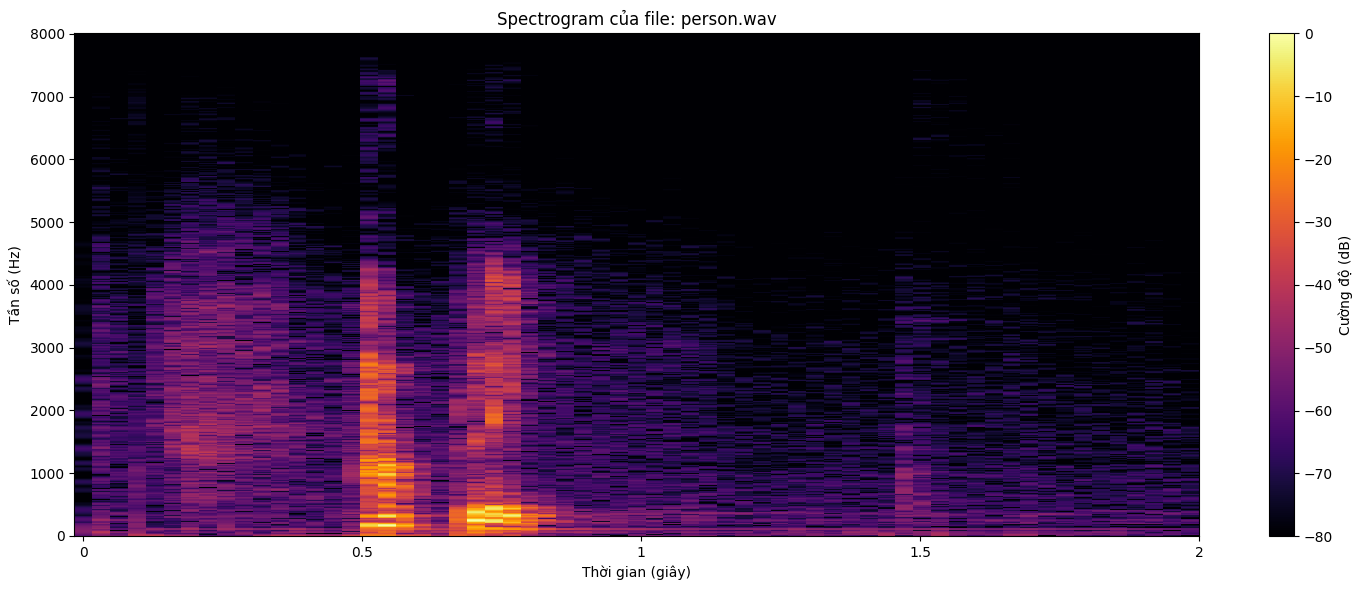

In [116]:
if len(speech) == 0:
    raise ValueError("Biến speech rỗng, không thể vẽ spectrogram")
if np.any(np.isnan(speech)) or np.any(np.isinf(speech)):
    raise ValueError("Biến speech chứa NaN hoặc Inf, cần kiểm tra lại")

# Chuẩn hóa biên độ (chỉ nếu cần)
if np.max(np.abs(speech)) > 1.0:
    audio_signal = speech / np.max(np.abs(speech))
else:
    audio_signal = speech

# Tính spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_signal, n_fft=1024, hop_length=512)), ref=np.max)

# Vẽ spectrogram
plt.figure(figsize=(15, 6))
librosa.display.specshow(
    D,
    sr=sample_rate,
    hop_length=512,
    x_axis='time',
    y_axis='hz',
    cmap='inferno'
)
plt.colorbar(label='Cường độ (dB)')
plt.title('Spectrogram của file: person.wav')
plt.xlabel('Thời gian (giây)')
plt.ylabel('Tần số (Hz)')
plt.tight_layout()
plt.show()

In [117]:
import torch
from typing import List

# Giả định PAD_ID đã được định nghĩa
PAD_ID = processor.tokenizer.encode("[PAD]")[0] 

# Hàm chèn [PAD] giữa các ID khác nhau, trừu khi đã có [PAD]
def insert_pad_between_different_ids(token_ids: List[int], pad_id: int) -> List[int]:
    result = []
    for i in range(len(token_ids)):
        result.append(token_ids[i])  
        if i < len(token_ids) - 1:
            if token_ids[i] != token_ids[i + 1] and token_ids[i] != pad_id and token_ids[i + 1] != pad_id:
                result.append(pad_id)
    return result

# Forward pass
with torch.no_grad():
    logits = model(input_values).logits

# Dự đoán ID token
predicted_ids = torch.argmax(logits, dim=-1)

# Chèn [PAD] giữa các ID khác nhau
predicted_ids = predicted_ids[0].tolist()  # Lấy batch đầu tiên
predicted_ids = insert_pad_between_different_ids(predicted_ids, PAD_ID)

# Decode ra text và tách thành mảng token
predicted_text = processor.batch_decode([torch.tensor(predicted_ids)], skip_special_tokens=True)[0]

# Xử lý chuỗi như gốc
predicted_text = predicted_text.replace("h#", "")
predicted_text = predicted_text.replace(" ", "[PAD]")

# Tách thành danh sách token
predicted_list = [item for item in predicted_text.split("[PAD]") if item != '']
print("Predicted phoneme list:", predicted_list)

Predicted phoneme list: ['hh', 'ah', 'p', 'l', 'iy']


In [118]:
import pronouncing
import re

def sentence_to_phonemes(sentence):
    words = sentence.lower().split()
    phoneme_sequence = []

    for word in words:
        phones = pronouncing.phones_for_word(word)
        if phones:
            phonemes = phones[0].split()
            cleaned_phonemes = [re.sub(r'\d', '', p).lower() for p in phonemes]
            phoneme_sequence.extend(cleaned_phonemes)
        else:
            phoneme_sequence.append(f"[unk:{word}]")  # cũng dùng chữ thường cho [UNK]

    return phoneme_sequence

# 🔎 Ví dụ sử dụng
sentence = "public"
phonemes = sentence_to_phonemes(sentence)
print(phonemes)


['p', 'ah', 'b', 'l', 'ih', 'k']


In [119]:
def map_similar_phonemes(phonemes):
    # Ánh xạ phoneme tương tự
    mapping = {
        'p': 'P',
        'b': 'P',
        'aa': 'aa',
        'ao': 'aa',
        'ih': 'ih',
        'ah': 'ih',
        'iy': 'ih',
        'er': 'r',
    }
    return [mapping.get(p, p) for p in phonemes]

In [120]:
import editdistance

def compute_per(pred_phonemes, ref_phonemes):
    pred_mapped = map_similar_phonemes(pred_phonemes)
    ref_mapped = map_similar_phonemes(ref_phonemes)

    distance = editdistance.eval(pred_mapped, ref_mapped)
    per = distance / len(ref_phonemes) if ref_phonemes else 0.0
    return 1-per


In [121]:
print(phonemes)
print(predicted_list)
compute_per(phonemes,predicted_list)

['p', 'ah', 'b', 'l', 'ih', 'k']
['hh', 'ah', 'p', 'l', 'iy']


0.6